# Seq2seq 으로 번역기 만들기 프로젝트



In [25]:
# 필요한 라이브러리 임포트 및 버전 확인
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
    
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

from konlpy.tag import Mecab
from tqdm import tqdm
import re
import tarfile
import os
import time
import io

mecab = Mecab()

print(pd.__version__)
print(tf.__version__)
print(mpl.__version__)
print(np.__version__)


1.3.3
2.6.0
3.4.3
1.21.4


## 함수 및 클래스 정의

In [23]:
# 함수 및 클래스

# 텍스트 전처리 함수 정의
def preprocess_sentence(sentence, lang="kor", s_token=False, e_token=False):
    
    sentence = sentence.lower().strip()
    sentence = re.sub(r'[“”«»]', '"', sentence)
    sentence = re.sub(r"[‘’‹›]", "'", sentence)
    
    if lang=="eng":
        if not re.search(r'[a-z]', sentence):
            sentence = ''
        else:
            sentence = re.sub(r'''([?.!,'"])''', r' \1 ', sentence)          # 구두점 따옴표 앞뒤로 공백
            sentence = re.sub(r'''[^a-z?.!,'"]+''', ' ', sentence)           # 알파벳+구두점 따옴표만 남기기

    elif lang=="kor":
        if not re.search(r'[가-힣]', sentence):
            sentence = ''
        else:
            sentence = re.sub(r'''[^가-힣?.!,'"]+''', ' ', sentence)             # 한글과 구두점 따옴표만 남기기
            tokens = mecab.morphs(sentence)                     # 형태소 단위 토큰화
            sentence = ' '.join(tokens)                         # 공백으로 토큰 구분 -> tokenizer 입력용
    else:
        raise ValueError(f"Unsupported lang: {lang}")
    
    if s_token:
        sentence = '<start> ' + sentence
    if e_token:
        sentence += ' <end>'
    
    sentence = re.sub(r'\s+', ' ', sentence).strip()
    
    if sentence == '<start> <end>':
        sentence = ''
        
    return sentence


# 토큰화
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE, filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,maxlen=MAX_LEN, padding='post')

    return tensor, tokenizer

# corpus 토큰 분석용
def analyze_corpus(corpus, top_k=50):
    # 1) 리스트 of token lists
    token_lists = [sent.split() for sent in corpus]
    # 2) flatten to 1d list
    all_tokens = [tok for sent in token_lists for tok in sent]
    
    # 3) 전체 고유 토큰 수
    vocab = set(all_tokens)
    vocab_size = len(vocab)
    
    # 4) 토큰별 빈도 카운트
    counter = Counter(all_tokens)
    total_tokens = len(all_tokens)
    
    # 5) 가장 자주 등장하는 top_k 토큰 및 비중
    topk = counter.most_common(top_k)
    topk_tokens, topk_counts = zip(*topk)
    topk_props = [cnt/total_tokens for cnt in topk_counts]
    
    # 6) top_k 커버리지 (누적 비중)
    cumulative = np.cumsum(topk_props)
    
    # 결과 리턴
    return {
        'vocab_size': vocab_size,
        'total_tokens': total_tokens,
        'token_freq': counter,             # Counter 객체
        'topk_tokens': topk_tokens,        # 리스트
        'topk_counts': topk_counts,        # 리스트
        'topk_props': topk_props,          # 리스트
        'topk_cumulative': cumulative,     # numpy array
    }

# Bahdanau Attention 구현
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W_dec = tf.keras.layers.Dense(units)
        self.W_enc = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, enc_outputs, dec_hidden):
        # enc_outputs: [batch, seq_len, units], dec_hidden: [batch, units]
        
        dec_hidden_time = tf.expand_dims(dec_hidden, 1)     # [batch, 1, units]
        score = self.V(tf.nn.tanh(self.W_enc(enc_outputs) + self.W_dec(dec_hidden_time)))
        attn_weights = tf.nn.softmax(score, axis=1)         # [batch, seq_len, 1]
        context = tf.reduce_sum(attn_weights * enc_outputs, axis=1)  # [batch, units]
        return context, tf.squeeze(attn_weights, -1)

# Encoder 정의
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, emb_dim, enc_units):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, emb_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True,
                                       return_state=True)
    def call(self, x):
        x = self.embedding(x)                          # [batch, seq_len, emb_dim]
        outputs, state = self.gru(x)                   # outputs: all states, state: last state
        return outputs, state

# Decoder 정의
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, emb_dim, dec_units):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, emb_dim)
        self.attention = BahdanauAttention(dec_units)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)
    def call(self, x, hidden, enc_outputs):
        context, attn_weights = self.attention(enc_outputs, hidden)
        x = self.embedding(x)                           # [batch, 1, emb_dim]
        x = tf.concat([tf.expand_dims(context, 1), x], axis=-1)
        outputs, state = self.gru(x, initial_state=hidden)
        logits = self.fc(tf.reshape(outputs, (-1, outputs.shape[2])))
        return logits, state, attn_weights


def loss_function(real, pred):
    mask = tf.cast(tf.not_equal(real, 0), dtype=pred.dtype)
    loss_ = loss_object(real, pred) * mask
    return tf.reduce_mean(loss_)

# 학습 스텝 함수
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    with tf.GradientTape() as tape:
        # 인코더 순전파도 tape 안에서!
        enc_out, enc_state = encoder(src, training=True)
        dec_hidden = enc_state
        dec_input = tf.expand_dims([dec_tok.word_index['<start>']] * src.shape[0], 1)

        loss = 0
        for t in range(1, tgt.shape[1]):
            preds, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_out, training=True)
            loss += loss_function(tgt[:, t], preds)
            dec_input = tf.expand_dims(tgt[:, t], 1)     # 모델 출력이 아닌 정답 입력으로 사용 -> teaching force

    variables = encoder.trainable_variables + decoder.trainable_variables
    grads = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(grads, variables))
    return loss / int(tgt.shape[1])



# 인퍼런스: 단일 문장 번역 함수
def translate(sentence):
    sentence = preprocess_sentence(sentence, lang="kor")
    seq = kor_tokenizer.texts_to_sequences([sentence])
    seq = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=max_len, padding='post')
    enc_out, enc_state = encoder(seq)
    dec_hidden = enc_state
    dec_input = tf.expand_dims([eng_tokenizer.word_index['<start>']], 0)
    result = []
    for _ in range(max_len):
        preds, dec_hidden, attn = decoder(dec_input, dec_hidden, enc_out)
        predicted_id = tf.argmax(preds[0]).numpy()
        token = eng_tokenizer.index_word.get(predicted_id, '<unk>')
        if token == '<end>': break
        result.append(token)
        dec_input = tf.expand_dims([predicted_id], 0)
    return ' '.join(result)

# attention map 출력을 위해 attention 반환 추가
def translate_with_attention(sentence):
    sentence = preprocess_sentence(sentence, lang="kor")
    seq = kor_tokenizer.texts_to_sequences([sentence])
    seq = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=MAX_LEN, padding='post')
    
    enc_out, enc_state = encoder(seq)
    dec_hidden = enc_state
    dec_input = tf.expand_dims([eng_tokenizer.word_index['<start>']], 0)
    
    result = []
    attentions = []  # 여기에 매 스텝 어텐션을 쌓아둡니다.
    
    for _ in range(MAX_LEN):
        preds, dec_hidden, attn = decoder(dec_input, dec_hidden, enc_out)
        attentions.append(attn[0].numpy())  # (seq_len,) 형태 추출
        
        predicted_id = tf.argmax(preds[0]).numpy()
        token = eng_tokenizer.index_word.get(predicted_id, '<unk>')
        if token == '<end>':
            break
        result.append(token)
        dec_input = tf.expand_dims([predicted_id], 0)
    
    return result, np.array(attentions)  # (T_dec, T_enc) 행렬

# attention map
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()



## 데이터 준비

In [4]:
#데이터 준비

# 다운로드 및 압축 해제
# tf.keras.utils.get_file 사용, extract=True로 자동 해제
data_tar = tf.keras.utils.get_file(
    origin='https://github.com/jungyeul/korean-parallel-corpora/raw/refs/heads/master/korean-english-news-v1/korean-english-park.train.tar.gz',
    extract=True,
)

# 파일 경로
data_dir = os.path.dirname(data_tar)
kor_path = os.path.join(data_dir, 'korean-english-park.train.ko')
eng_path = os.path.join(data_dir, 'korean-english-park.train.en')

# 파일 읽기
kor_lines = open(kor_path, 'r', encoding='utf-8').read().splitlines()
eng_lines = open(eng_path, 'r', encoding='utf-8').read().splitlines()

# 데이터 확인
print(len(kor_lines))
print(len(eng_lines))

94123
94123


## EDA 및 전처리
### 데이터 수 및 결측 중복 확인
- 중복이 많이 존재함

In [5]:

# === EDA: 데이터 상태 확인 ===
# 데이터프레임 생성
df = pd.DataFrame({'kor': kor_lines, 'eng': eng_lines})

# 전체 샘플 수 확인
print(f"전체 샘플 개수: {len(df)}")
# 결측치 확인
print("결측치 개수:\n", df.isnull().sum())

# 빈 문자열 확인
empty_kor = (df['kor'] == '').sum()
empty_eng = (df['eng'] == '').sum()
print(f"빈 문자열 kor: {empty_kor}, eng: {empty_eng}")

# 중복 확인
dup_count = df.duplicated().sum()
print(f"전체 중복 쌍 개수: {dup_count}")

# 중복 제거
df = df.drop_duplicates().reset_index(drop=True)
print(f"중복 제거 후 샘플 개수: {len(df)}")


#print(df['kor'].duplicated().sum())
#df_sorted = df.sort_values('kor')
#df_sorted[df_sorted['kor'].duplicated(keep=False)]

#df[df['kor'].duplicated()].sort_values('kor')
#print("\n")
#print(df['eng'].duplicated().sum())
#df[df['eng'].duplicated()].sort_values('eng')

전체 샘플 개수: 94123
결측치 개수:
 kor    0
eng    0
dtype: int64
빈 문자열 kor: 0, eng: 0
전체 중복 쌍 개수: 15155
중복 제거 후 샘플 개수: 78968


### 전처리
- 언어별 전처리 적용 (구두점 및 따옴표는 유지) 
- 토큰별 공백문자 구분
- 타겟인 영어는 <start>, <end> 토큰 추가 
- 한영 set 중복 제거

In [6]:
# 데이터 전처리

# 병렬 코퍼스 전처리 후 중복 제거
cleaned_corpus  = set()
kor_clean_line = []
eng_clean_line = []
for k, e in zip(kor_lines, eng_lines):
    if k and e:
        clean_k = preprocess_sentence(k,lang="kor")
        clean_e = preprocess_sentence(e,lang="eng",s_token=True, e_token=True)
        cleaned_corpus.add((clean_k,clean_e))
        # EDA 용
        kor_clean_line.append(clean_k)  
        eng_clean_line.append(clean_e)



###  EDA -  전처리 후 재확인
- 언어별 중복 확인 ( 한국어는 같은데 영어가 다르거나 영어는 같은데 한국어가 다름 )
- 토큰화 이후 빈문자열 확인 ( 언어별 중복 제거시 제거됨 확인 )

In [7]:
# === EDA: 데이터 상태 확인 ===
df = pd.DataFrame({'kor': kor_clean_line, 'eng': eng_clean_line})
print(f"전체 샘플 개수: {len(df)}")


# 중복 확인 및 제거
dup_count = df.duplicated().sum()
print(f"중복 쌍 개수: {dup_count}")
df.drop_duplicates(inplace=True)
print(f"중복 제거 후 샘플 개수: {len(df)}")

# 언어별 중복
dup_count = df.duplicated('kor').sum()
print(f"kor 중복 개수: {dup_count}")
dup_count = df.duplicated('eng').sum()
print(f"eng 중복 개수: {dup_count}")

# kor 또는 eng 중복(첫 등장 포함)을 모두 True로 표시
mask = df['kor'].duplicated(keep=False) | df['eng'].duplicated(keep=False)

# 중복된 모든 행을 제거
df = df[~mask].reset_index(drop=True)
print(f"언어별 중복 제거 후 샘플 개수: {len(df)}")



# 결측치 및 빈문자열 확인
print("결측치 개수:\n", df.isnull().sum())
empty_kor = (df['kor'] == '').sum()
empty_eng = (df['eng'] == '').sum()
print(f"빈 문자열 kor: {empty_kor}, eng: {empty_eng}")

df[['kor','eng']] = df[['kor','eng']].replace('', np.nan)
df.dropna(subset=['kor','eng'], inplace=True)
print(f"빈 문자 제거 후 샘플 개수: {len(df)}")


전체 샘플 개수: 94123
중복 쌍 개수: 15323
중복 제거 후 샘플 개수: 78800
kor 중복 개수: 1691
eng 중복 개수: 3337
언어별 중복 제거 후 샘플 개수: 71090
결측치 개수:
 kor    0
eng    0
dtype: int64
빈 문자열 kor: 0, eng: 0
빈 문자 제거 후 샘플 개수: 71090


### EDA - 문장 길이(토큰수) 확인
- 약간 적은 수로 불균형
- 적은 수의 긴 문장들 존재
- 언어간 토큰수 일반적이지 않은 경우 존재 확인
- 짧은 문장이나 긴문장 모두 언어 언어간 토큰수 비율이 불균형하면 잘못 매칭되었거나 문자가 짤린 경우가 많음

count    71090.000000
mean        29.815445
std         12.124043
min          1.000000
25%         21.000000
50%         29.000000
75%         37.000000
max        129.000000
Name: len_kor, dtype: float64
count    71090.000000
mean        27.916191
std         11.245687
min          3.000000
25%         20.000000
50%         27.000000
75%         35.000000
max        103.000000
Name: len_eng, dtype: float64
길이 비율(eng/kor) 통계:
 count    71090.000000
mean         0.916480
std          0.458956
min          0.110000
25%          0.710000
50%          0.850000
75%          1.030000
max         35.000000
Name: length_ratio, dtype: float64


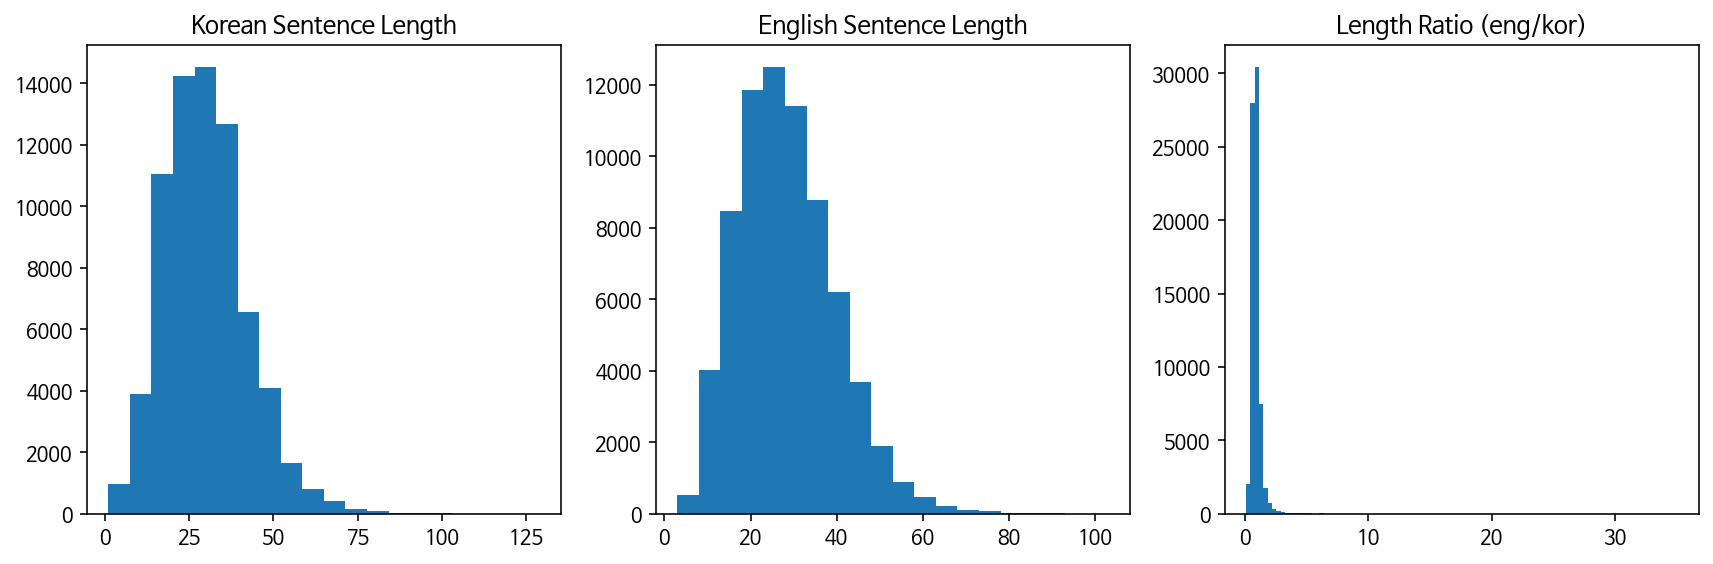

In [8]:
# 한국어 문장 길이 분포
df['len_kor'] = df['kor'].str.split().map(len)
print( df['len_kor'].describe())

# 영어 길이
df['len_eng'] = df['eng'].str.split().map(len)  # start end token 2개
print(df['len_eng'].describe())

# 길이 비율 (영어/한국어) 분포
df['length_ratio'] = ((df['len_eng']-2) / df['len_kor']).round(2)
print("길이 비율(eng/kor) 통계:\n", df['length_ratio'].describe())

# 비율 히스토그램 시각화
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(df['len_kor'], bins=20)
plt.title('Korean Sentence Length')
plt.subplot(1,3,2)
plt.hist(df['len_eng'], bins=20)
plt.title('English Sentence Length')
plt.subplot(1,3,3)
plt.hist(df['length_ratio'], bins=100)
plt.title('Length Ratio (eng/kor)')
plt.tight_layout()
plt.show()


In [9]:
df[df['length_ratio']>4 ]

,kor,eng,len_kor,len_eng,length_ratio
93,핵무기 개발 완료 를 공식 발표 한 북한,<start> the studio later retracted the stateme...,8,39,4.62
154,월 이 면 폐기 될 미르 우주 정거장,<start> the year old mir space station will be...,8,35,4.12
1451,어휘 콩고 화산 폭발 로 명 이상 사망,<start> lava edged with black crust inched thr...,8,37,4.38
1978,클린턴 행정부 와 일본 정부 는 비틀거려 왔 습니다,<start> the clinton administration and the jap...,9,44,4.67
3475,"보복 , 응보",<start> ' ' i decided to go to the americans a...,3,22,6.67
...,...,...,...,...,...
70135,' . 워싱턴 에서 북한 인권 국제 회의 열려 .,"<start> a one day , u . s . government funded ...",10,60,5.80
70403,"외부 생식기 , 외음부","<start> the musicians , along with the vocalis...",4,19,4.25
70803,". 성기 노출 인디 밴드 , 집행유예 석방",<start> seoul southern district court said yes...,8,59,7.12
70849,타격 을 입 다,"<start> lacking that , he says , a bad situati...",4,19,4.25


In [10]:
print(len(df[df['length_ratio']<0.25]))
df[df['length_ratio']<0.25].sample(10)

153


,kor,eng,len_kor,len_eng,length_ratio
34898,"콜 기자 는 사르코지 대통령 의 모습 에 대해 "" 그 는 미소 를 보이 는 등 행복...","<start> "" and then he noticed us taking pictur...",67,17,0.22
10127,이번 영화 에서 두 커플 의 열정 적 인 베드 씬 은 존재 하 지 않 는다 .,<start> a passionate interlude ? <end>,18,6,0.22
34060,영화 관계자 들 은 이 영화 를 통해 악화 되 가 는 지구 온난 화 현상 에 대한 ...,<start> warming will increasingly focus on sol...,37,9,0.19
54267,브란카토 와 아 멘토 가 집 으로 들어갔 을 때 이웃 주민 인 엔초 테 기 가 상황...,<start> came outside to investigate . <end>,29,7,0.17
20166,"윌리엄스 는 "" 우승 문턱 까지 갔 지만 윌리엄스 라는 이름 을 가진 여자 가 타이...","<start> serena williams , the defending <end>",25,7,0.20
53685,"부시 대통령 은 "" 여기 있 던 취재 기자 들 이 사과 했 다 "" 며 "" 그 들 은...",<start> bush told a reporter in response to a ...,59,15,0.22
70671,경찰 들 이 교통 마비 상태 의 완화 를 위해 대거 투입 되 면서 농민 소유 차량 ...,<start> more than arrests were made . <end>,35,8,0.17
24553,이 브로슈어 에 는 어부 들 이 배 에서 쥐 를 박멸 시키 는 방법 과 쥐덫 을 놓...,<start> brochures to educate mariners on how t...,92,20,0.20
28845,팰 러 세이 즈 메디컬 센터 직원 여명 이 영화배우 조지 클리 니 의 개인 의료 기...,<start> cigarettes are percent pricier . <end>,27,7,0.19
52988,소속 케 츠 마르지 크 의 조사 팀 은 뼈 들 을 조합 하 는 작업 을 위해 빠르 ...,<start> katzmarzyk ' s team from the icmp <end>,29,9,0.24


In [11]:
df[df['len_kor']<3]

,kor,eng,len_kor,len_eng,length_ratio
1185,신분 직업,<start> learn how to talk the walk <end>,2,8,3.0
3775,흑색선전,<start> pyongyang calls the allegations a smea...,1,10,8.0
4373,단장,<start> ex the alliance was forged in the cruc...,1,13,11.0
4499,인기 ',"<start> authority to make a film of it , trans...",2,18,8.0
4589,외딴 곳,<start> the area is sparsely populated . <end>,2,8,3.0
...,...,...,...,...,...
68281,철도청,<start> korean national railroad <end>,1,5,3.0
68370,연예인,"<start> long before american idol , there were...",1,19,17.0
68797,흘러내려가 다,<start> water rushing down a road from a big w...,2,13,5.5
70019,탄핵 재판,"<start> on nbc ' s today show , blagojevich sa...",2,34,16.0


In [12]:
df[df['len_eng']<4]

,kor,eng,len_kor,len_eng,length_ratio
8328,남자 들,<start> men <end>,2,3,0.5
8333,가족,<start> family <end>,1,3,1.0
8865,음식,<start> food <end>,1,3,1.0
8871,햇빛,<start> sunlight <end>,1,3,1.0
9975,과일,<start> fruits <end>,1,3,1.0
9983,양파,<start> onions <end>,1,3,1.0
10039,코브,<start> cobb <end>,1,3,1.0
10387,바리 백스,<start> varivax <end>,2,3,0.5
10394,조스타 백스,<start> zostavax <end>,2,3,0.5
12768,세부 사항,<start> details <end>,2,3,0.5


In [13]:
df[df['len_kor']>50]

,kor,eng,len_kor,len_eng,length_ratio
4,정보 관리 들 은 동남 아시아 에서 의 선박 들 에 대한 많 은 테러 계획 들 이 ...,<start> intelligence officials have revealed a...,58,43,0.71
5,이 지역 에 있 는 미국 선박 과 상업 용 선박 들 에 대한 알카에다 의 테러 시도...,<start> after learning of several foiled al qa...,79,51,0.62
6,"국립 과학 학회 가 발표 한 새 보고서 에 따르 면 , 복잡 한 임무 를 수행 해야...",<start> caffeine can help increase reaction ti...,64,43,0.64
10,"약 밀리그램 의 , 비슷 한 분량 의 카페인 은 또한 육체 적 지구력 을 강화 시키...","<start> a similar dose of caffeine , about mg ...",55,39,0.67
21,말레이시아 의 수도 쿠 알라 룸 푸르 에서 열리 는 이틀 간 의 회담 에서 는 년 ...,<start> the two days of meetings in the malays...,68,52,0.74
...,...,...,...,...,...
71003,""" 미군 은 민간인 의 사망 에 대해 부인 하 고 있 으며 , 한 사진 에 는 미군...","<start> "" the us denied any civilians were kil...",57,34,0.56
71023,"성명 은 미얀마 에서 의 "" 평화 적 인 시위대 에 대한 폭력 사용 을 강하 게 개...","<start> the statement "" strongly deplores the ...",51,43,0.80
71024,"성명 은 또한 미얀마 군정 에 반대파 지도자 인 아웅산수치 와 의 "" 성실 한 대화...",<start> it also calls for the early release of...,51,38,0.71
71035,""" 군 최고 통수 권 자 로서 , 정보 의 중요 성 을 이해 하 고 있 으며 이 나...",<start> i bear the responsibility for keeping ...,53,28,0.49


In [14]:
df[df['len_eng']>50]

,kor,eng,len_kor,len_eng,length_ratio
5,이 지역 에 있 는 미국 선박 과 상업 용 선박 들 에 대한 알카에다 의 테러 시도...,<start> after learning of several foiled al qa...,79,51,0.62
21,말레이시아 의 수도 쿠 알라 룸 푸르 에서 열리 는 이틀 간 의 회담 에서 는 년 ...,<start> the two days of meetings in the malays...,68,52,0.74
63,유럽 과 부시 는 이라크 에 대한 새 유엔 결의안 초안 에 군사 행동 을 통한 위협...,<start> europe and bush have been at loggerhea...,55,52,0.91
105,"한국 이 주 일 근무 에서 미국 , 일본 및 서구 유럽 에서 일반 화 되 어 있 는...",<start> the three wage warriors and millions o...,67,51,0.73
122,국토 안 보부 신설 법안 에 서명 한 부시 부시 대통령 이 내각 수준 의 국토 안 ...,<start> findings from an inquiry by the house ...,50,61,1.18
...,...,...,...,...,...
70783,오늘 의 코리아 헤럴드 에 따르 면 정부 에서 임시직 고용자 의 근무 조건 을 개선...,<start> the government move stirred worries am...,48,75,1.52
70803,". 성기 노출 인디 밴드 , 집행유예 석방",<start> seoul southern district court said yes...,8,59,7.12
70903,그러나 평검사 들 은 그 합의 가 그 들 과 국민 의 합의 없이 양쪽 수뇌부 들 간...,"<start> however , junior prosecutors criticize...",56,52,0.89
70989,정치 전문가 들 은 이번 선거 에 가지 의 가능 성 을 점치 는데 특히 주요 관심 ...,<start> political analysts say there is a high...,28,55,1.89


### 전처리 - 추가
- 언어별 중복 제거 
- MAX LEN 으로 길이 필터링 
    - EDA를 결과를 바탕으로 하면 조금 크면 좋을듯하나 시간이 부족해 40으로 결정
 

In [15]:
MAX_LEN = 40

# 필터링 전/후 샘플 카운트 비교 함수 (토큰 길이 40 이하)
def filter_by_length(df, max_len=MAX_LEN):
    return df[(df['len_kor'] <= max_len) & (df['len_eng'] <= max_len)]
df_filtered = filter_by_length(df)
print(f"길이<={MAX_LEN} 필터 전: {len(df)}, 필터 후: {len(df_filtered)}")



길이<=40 필터 전: 71090, 필터 후: 54737


In [17]:
# 언어별 중복 제거
from collections import Counter

# cleaned_corpus는 {(kor, eng), ...} 형태의 set
kors, engs = zip(*cleaned_corpus)

kor_cnt = Counter(kors)
eng_cnt = Counter(engs)

# kor이 유일하고 eng도 유일한 튜플만 남기기
filtered_corpus = {
    (k, e)
    for k, e in cleaned_corpus
    if kor_cnt[k] == 1 and eng_cnt[e] == 1
}

# 길이 필터링 with MAX_LEN
kor_corpus, eng_corpus = [], []
for clean_k, clean_e in filtered_corpus:
    klen = len(clean_k.split())
    elen = len(clean_e.split())
    if klen > 0 and elen > 0 and \
        klen <= MAX_LEN and elen <= MAX_LEN:
        kor_corpus.append(clean_k)
        eng_corpus.append(clean_e)

print(len(kor_corpus))
print(len(eng_corpus))

54737
54737


### 언어별 corpus 분석
- 총 토큰 수 
- 총 unique vocab 수
- 토큰 빈도 및 커버리지 분석
    - 토큰 빈도 3회 이상이며 95%이상 커버가 가능한 17500으로 vocab 사이즈 결정

한글 vocab size: 35763
한글 토큰 총개수: 1382525
영어 vocab size: 37268
영어 토큰 총개수: 1305633
한글에서 빈도 > 3 토큰 개수: 17536
영어에서 빈도 > 3 토큰 개수: 17686
Top-5000 커버리지 ▶ 한글: 91.95%, 영어: 91.36%
Top-10000 커버리지 ▶ 한글: 96.04%, 영어: 95.66%
Top-15000 커버리지 ▶ 한글: 97.75%, 영어: 97.46%
Top-20000 커버리지 ▶ 한글: 98.66%, 영어: 98.43%
Top-25000 커버리지 ▶ 한글: 99.22%, 영어: 99.06%
Top-30000 커버리지 ▶ 한글: 99.58%, 영어: 99.44%


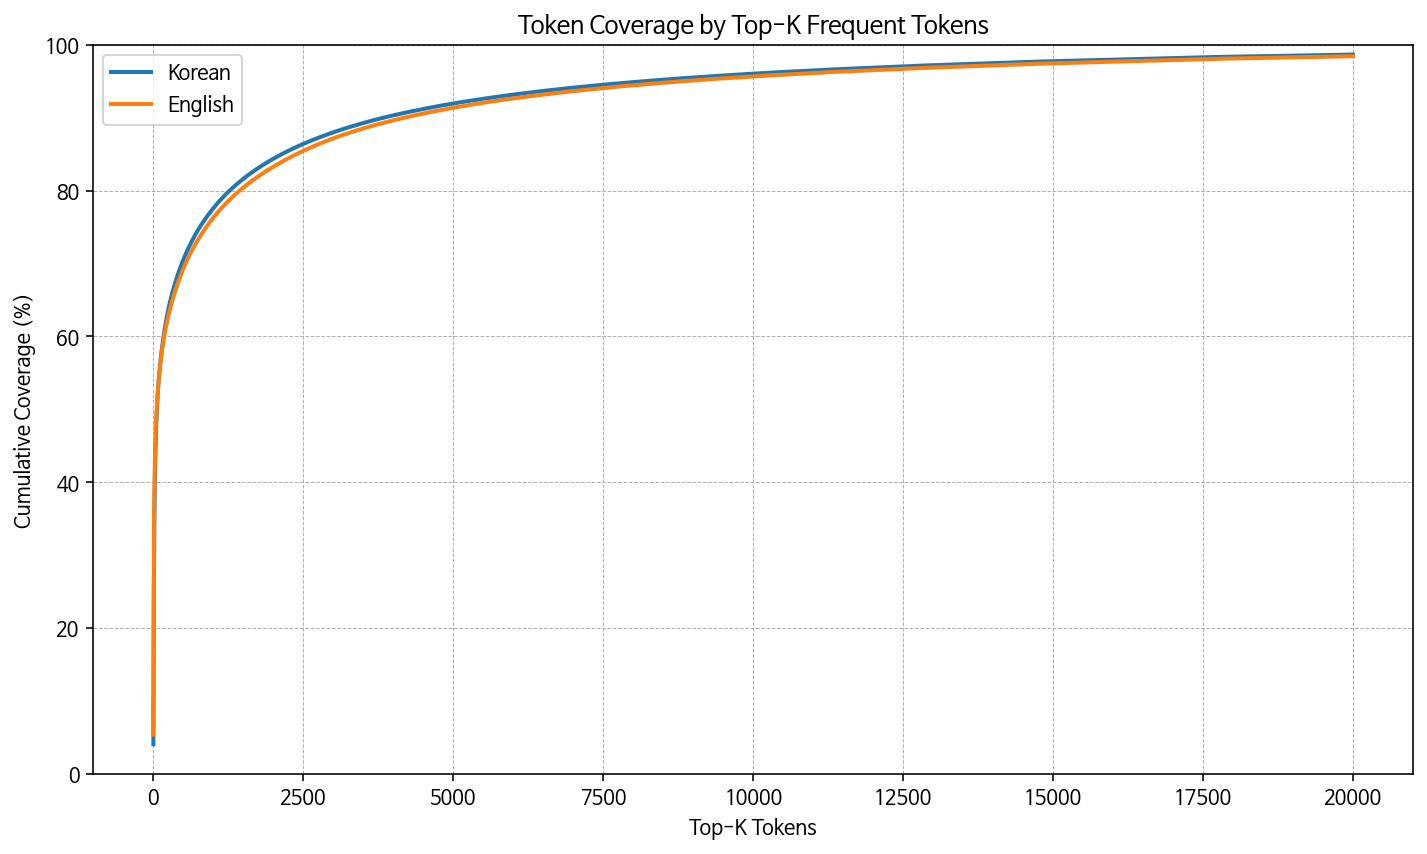

In [18]:
# kor_corpus 분석
kor_stats = analyze_corpus(kor_corpus, top_k=30000)
print("한글 vocab size:", kor_stats['vocab_size'])
print("한글 토큰 총개수:", kor_stats['total_tokens'])

# eng_corpus 분석
eng_stats = analyze_corpus(eng_corpus, top_k=30000)
print("영어 vocab size:", eng_stats['vocab_size'])
print("영어 토큰 총개수:", eng_stats['total_tokens'])

n = 3
# kor_stats['token_freq'] 는 Counter 객체
rare_kor = [tok for tok, cnt in kor_stats['token_freq'].items() if cnt >= n]
rare_eng = [tok for tok, cnt in eng_stats['token_freq'].items() if cnt >= n]

print(f"한글에서 빈도 > {n} 토큰 개수: {len(rare_kor)}")
print(f"영어에서 빈도 > {n} 토큰 개수: {len(rare_eng)}")


ks = [5000, 10000, 15000, 20000, 25000, 30000]
# kor_stats, eng_stats 에서 topk_cumulative 를 가져왔다고 가정
for k in ks:
    kor_cov = kor_stats['topk_cumulative'][k-1] * 100
    eng_cov = eng_stats['topk_cumulative'][k-1] * 100
    print(f"Top-{k} 커버리지 ▶ 한글: {kor_cov:.2f}%, 영어: {eng_cov:.2f}%")

# 그래프 그리기
    
# 실제 커버리지 배열 길이
max_kor = len(kor_stats['topk_cumulative'])
max_eng = len(eng_stats['topk_cumulative'])

# 두 언어 중 작은 길이만큼만 그리기
k_plot = min(20000, max_kor, max_eng)

x = np.arange(1, k_plot + 1)
y_kor = kor_stats['topk_cumulative'][:k_plot] * 100
y_eng = eng_stats['topk_cumulative'][:k_plot] * 100

plt.figure(figsize=(10, 6))
plt.plot(x, y_kor, label='Korean', linewidth=2)
plt.plot(x, y_eng, label='English', linewidth=2)
plt.xlabel('Top-K Tokens')
plt.ylabel('Cumulative Coverage (%)')
plt.title('Token Coverage by Top-K Frequent Tokens')
plt.ylim(0, 100)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## 토큰화 및 인코더 디코더용 데이터 준비

In [20]:
# 토큰화 및 vocab 생성
VOCAB_SIZE = 17500     #  각 언어별로 3번 이상은 나오는 토큰수를 기준으로 잡음

kor_seqs, kor_tokenizer = tokenize(kor_corpus)
eng_seqs, eng_tokenizer = tokenize(eng_corpus)

# 디코더 입력과 타깃 분리 for teaching force
dec_inputs = eng_seqs[:, :-1]    # <start> 없이 생성할 부분
dec_targets = eng_seqs[:, 1:]    # 첫 토큰 뒤부터 <end> 포함

# tf.data.Dataset 준비 (배치, 셔플)
BUFFER_SIZE = len(kor_seqs)
BATCH_SIZE = 64
dataset = tf.data.Dataset.from_tensor_slices((kor_seqs, dec_inputs, dec_targets))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)



## 모델 설계

In [21]:
#모델 설계

# 모델 하이퍼파라미터 설정
VOCAB_KOR = len(kor_tokenizer.word_index) + 1
VOCAB_ENG = len(eng_tokenizer.word_index) + 1

EMB_DIM = 256
UNITS = 512

encoder = Encoder(VOCAB_KOR, EMB_DIM, UNITS)
decoder = Decoder(VOCAB_ENG, EMB_DIM + UNITS, UNITS)  
# (Embedding + context) 차원 = EMB_DIM + UNITS


# Optimizer 및 Loss 함수 정의
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')



## 모델 훈련 

Epoch 1: 100%|██████████| 855/855 [03:59<00:00,  3.57it/s]
/tmp/ipykernel_121/1122789064.py:214: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_121/1122789064.py:215: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


Epoch 1, Loss: 2.4834
오바마는 대통령이다.  ->  is the white house .


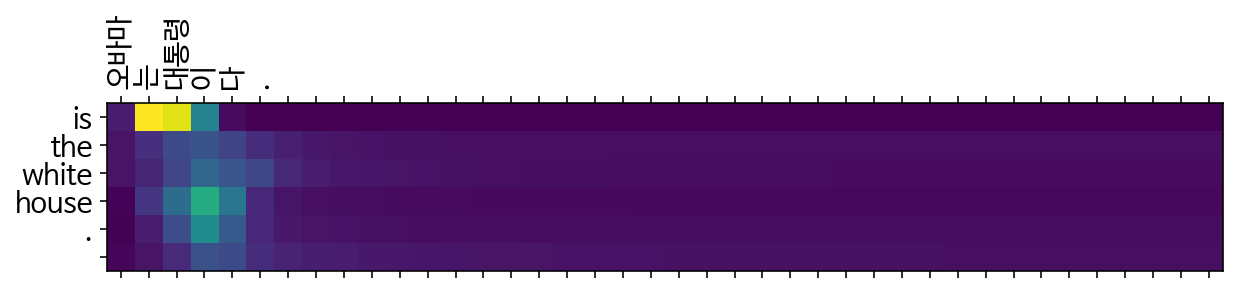

시민들은 도시 속에 산다.  ->  are the most dangerous .


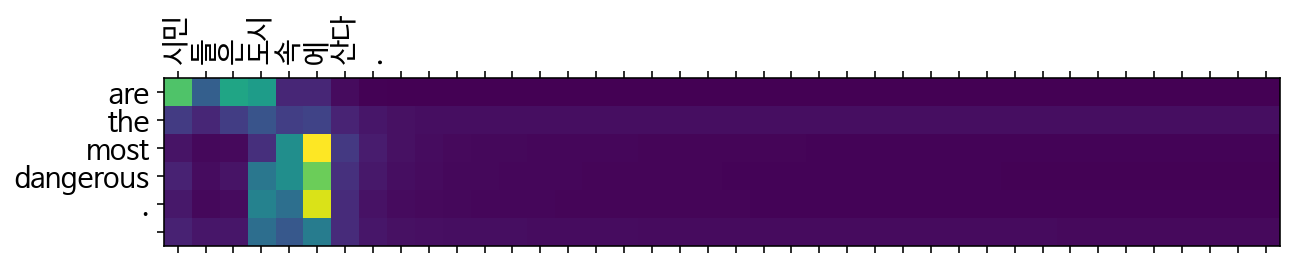

커피는 필요 없다.  ->  ' s a little good .


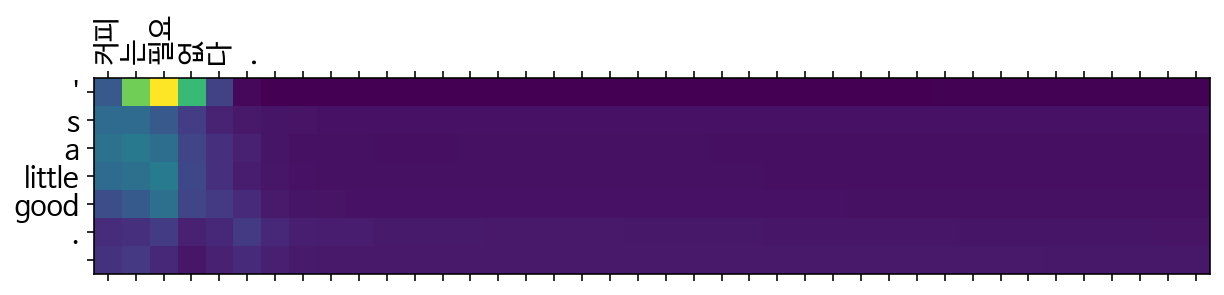

일곱 명의 사망자가 발생했다.  ->  least people were killed in the attack .


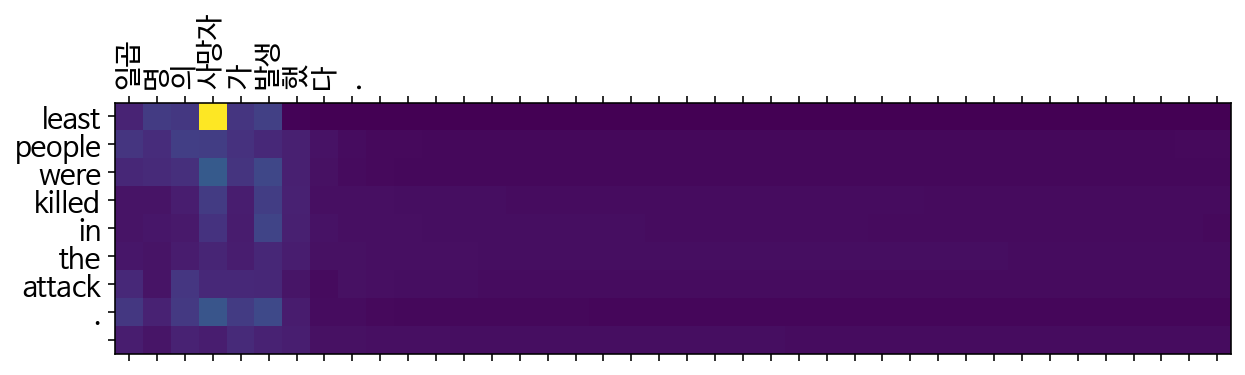

Epoch 2: 100%|██████████| 855/855 [03:59<00:00,  3.57it/s]


Epoch 2, Loss: 2.2117
오바마는 대통령이다.  ->  is the president .


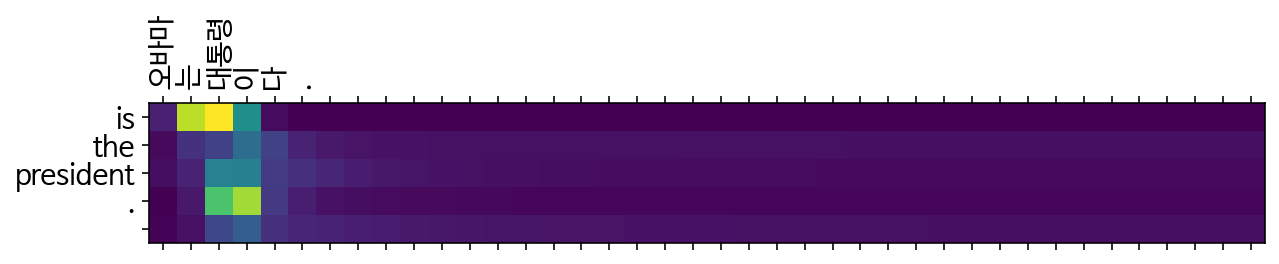

시민들은 도시 속에 산다.  ->  are also known to be the second in the region .


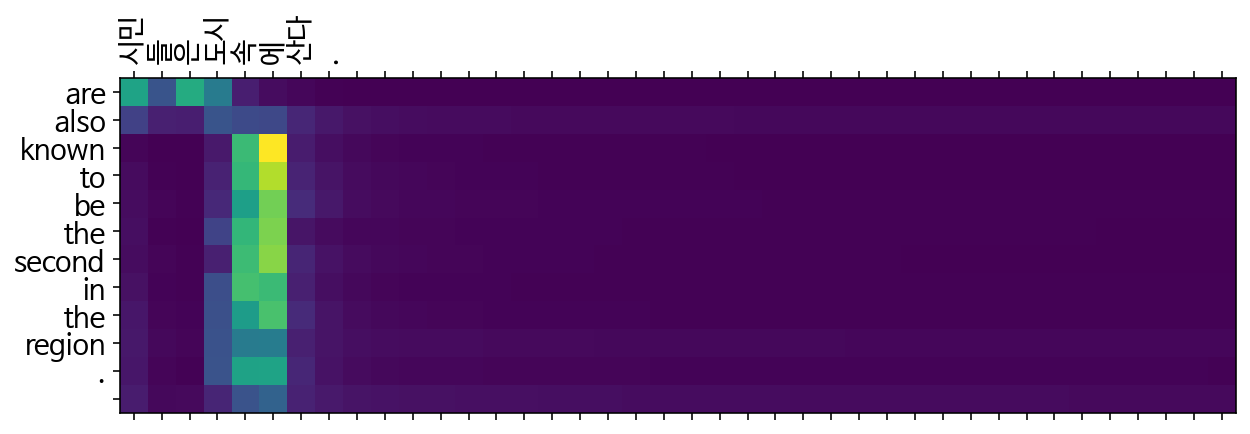

커피는 필요 없다.  ->  brain brain


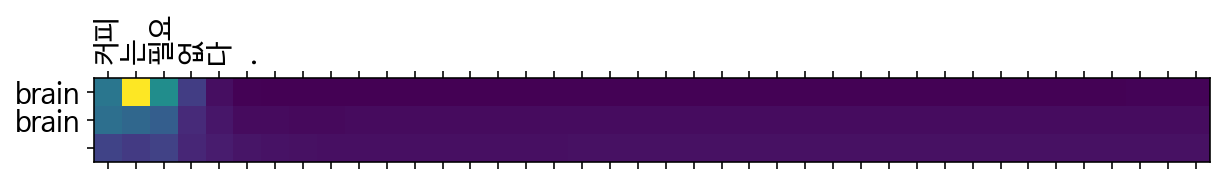

일곱 명의 사망자가 발생했다.  ->  least people were killed .


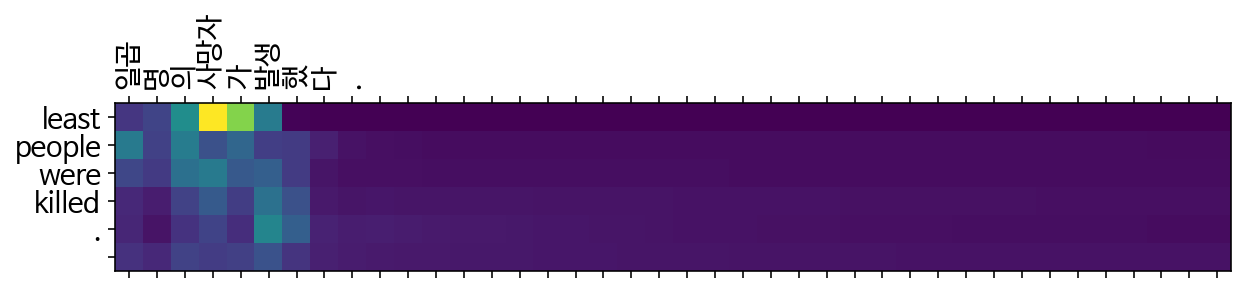

Epoch 3: 100%|██████████| 855/855 [03:59<00:00,  3.57it/s]


Epoch 3, Loss: 1.9791
오바마는 대통령이다.  ->  is the first time in the oval office .


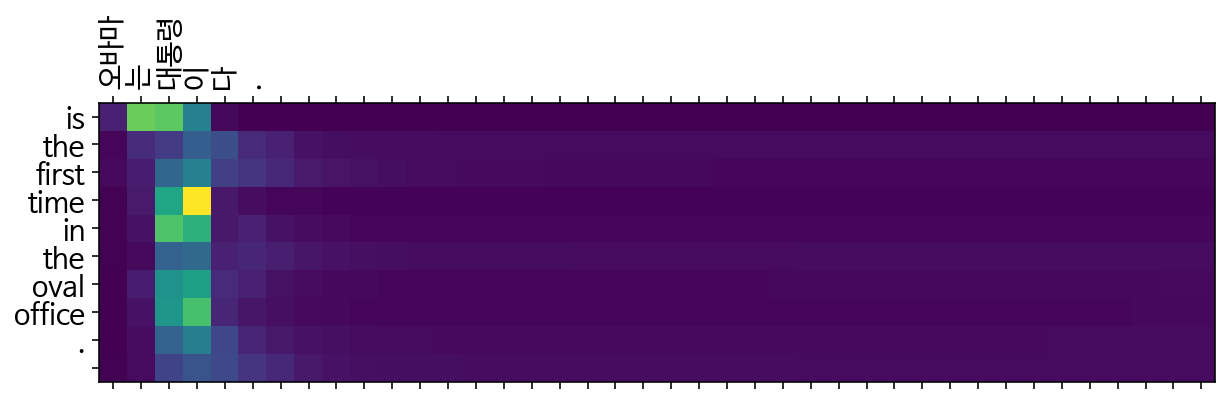

시민들은 도시 속에 산다.  ->  of the buildings are in place .


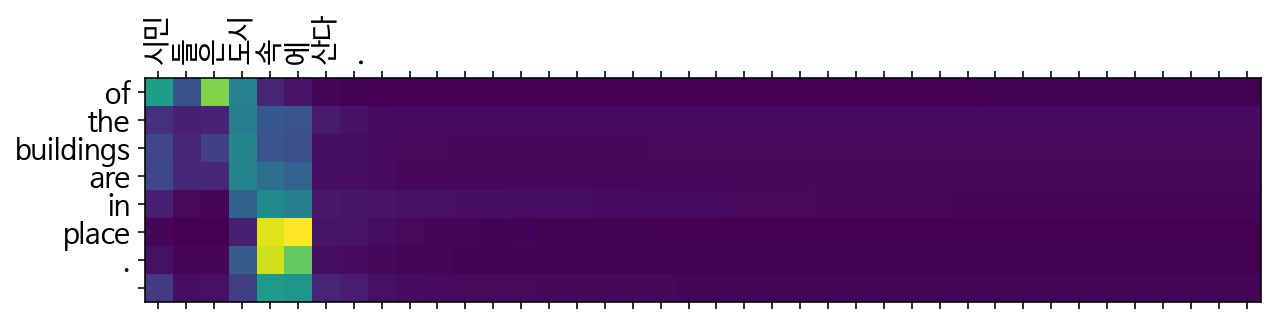

커피는 필요 없다.  ->  coffee is a big factor .


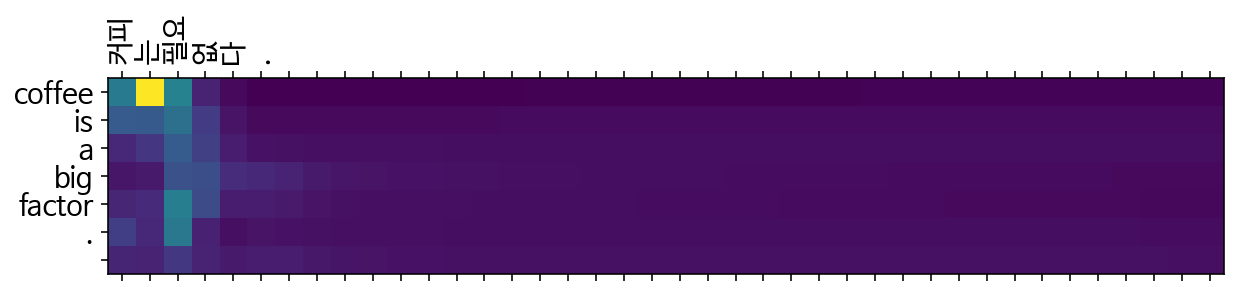

일곱 명의 사망자가 발생했다.  ->  least people were killed .


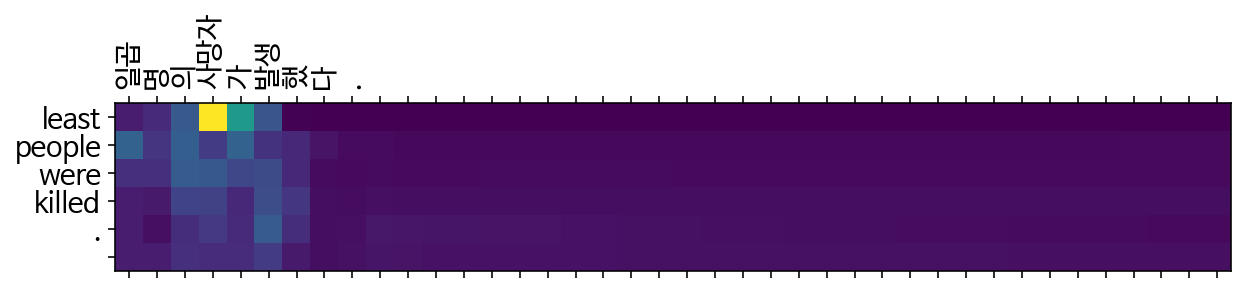

Epoch 4: 100%|██████████| 855/855 [03:59<00:00,  3.57it/s]


Epoch 4, Loss: 1.7693
오바마는 대통령이다.  ->  is a .


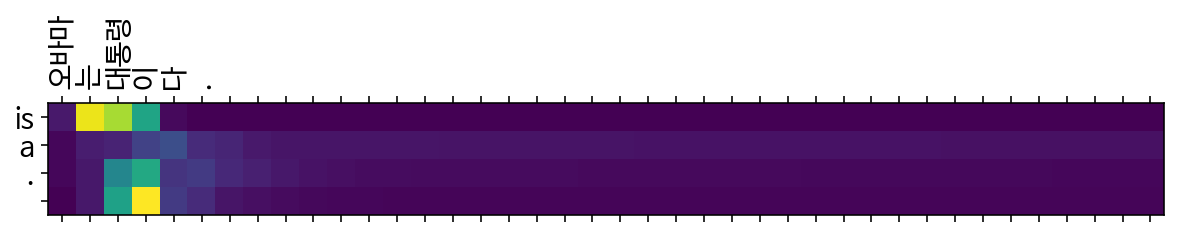

시민들은 도시 속에 산다.  ->  of the tourists are in the town .


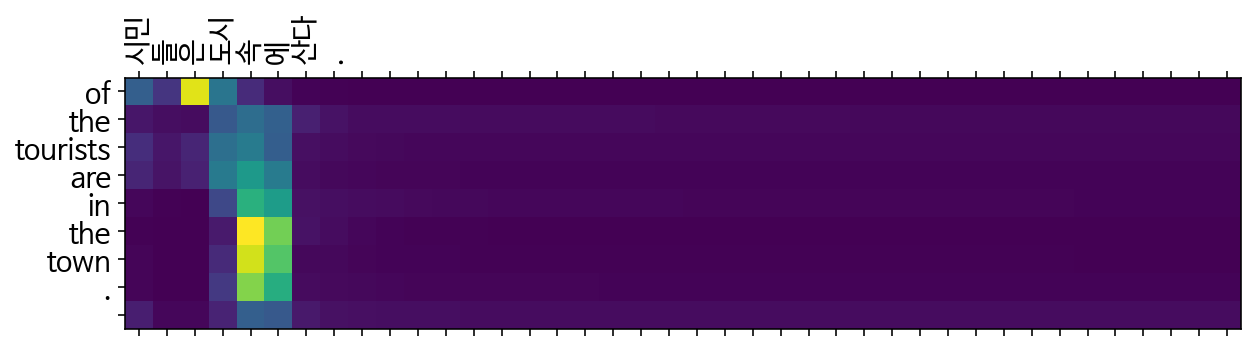

커피는 필요 없다.  ->  coffee is a good thing .


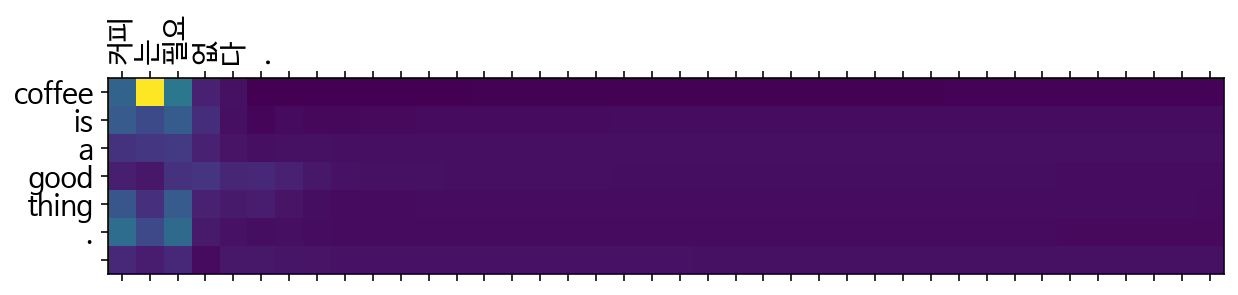

일곱 명의 사망자가 발생했다.  ->  least people were killed .


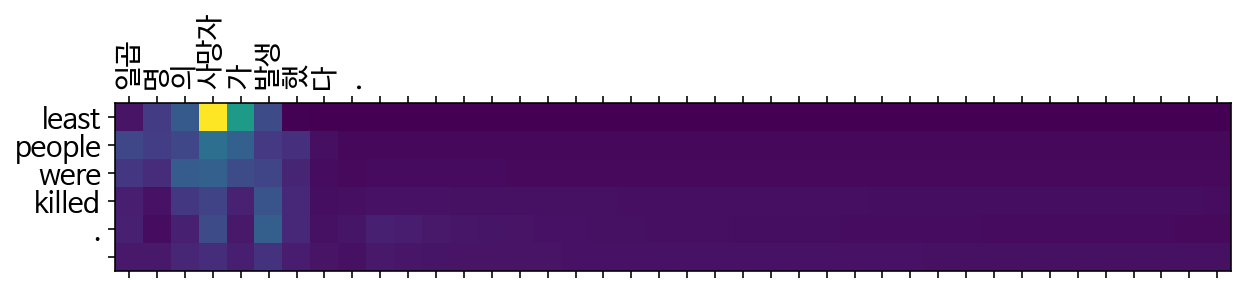

Epoch 5: 100%|██████████| 855/855 [03:59<00:00,  3.57it/s]


Epoch 5, Loss: 1.5811
오바마는 대통령이다.  ->  was the first time in the oval office .


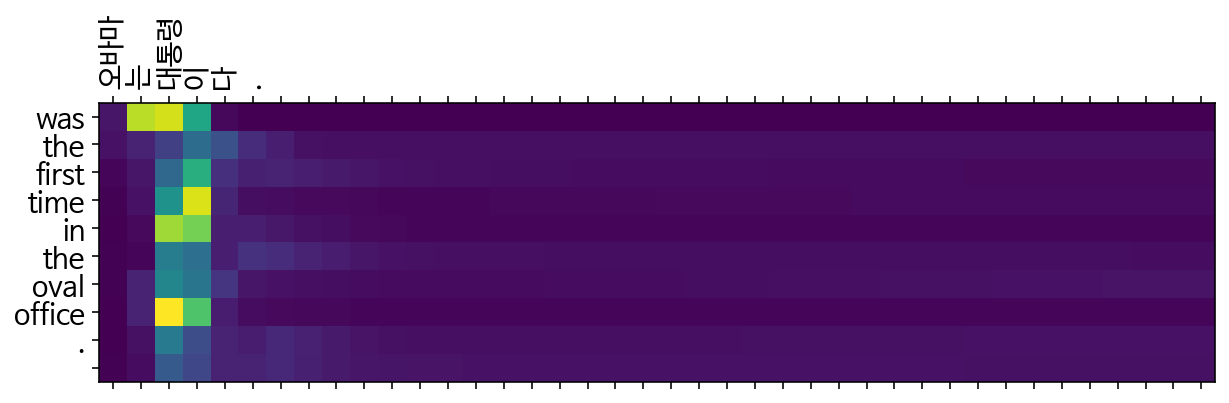

시민들은 도시 속에 산다.  ->  are also on the streets .


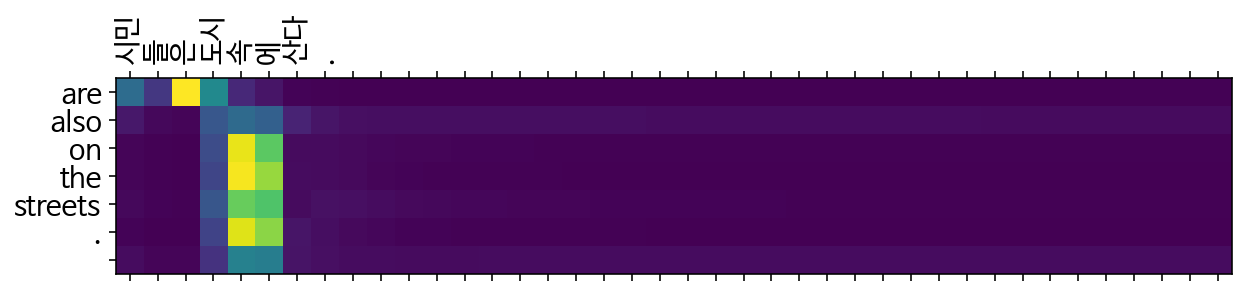

커피는 필요 없다.  ->  coffee is a big factor .


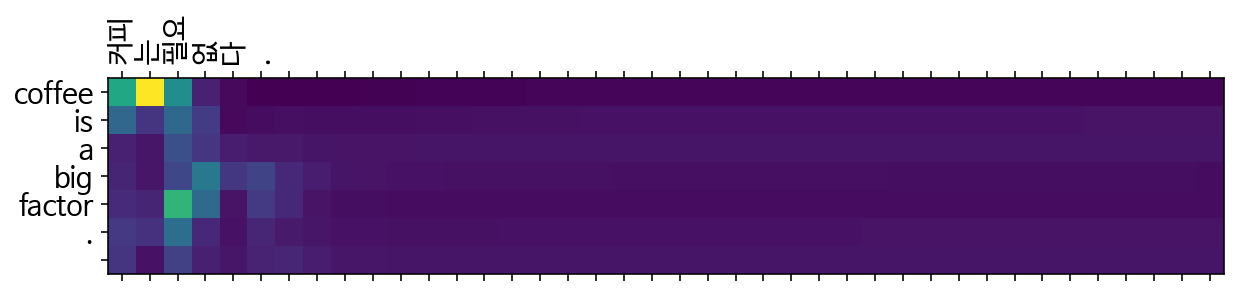

일곱 명의 사망자가 발생했다.  ->  least people have died .


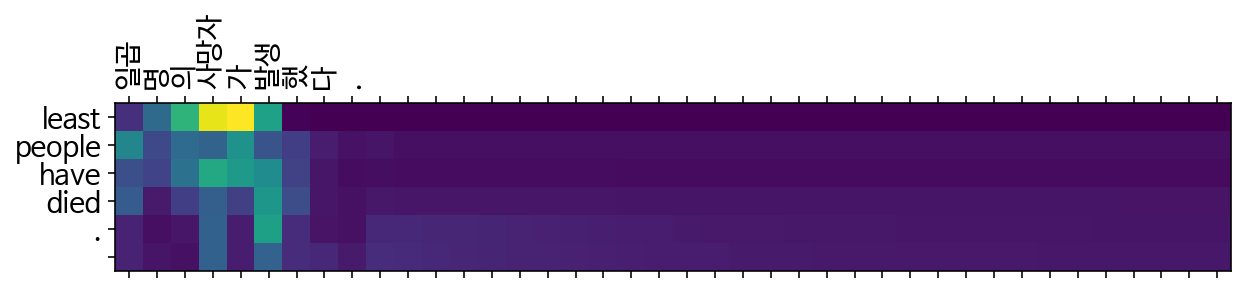

Epoch 6: 100%|██████████| 855/855 [03:59<00:00,  3.57it/s]


Epoch 6, Loss: 1.4166
오바마는 대통령이다.  ->  was the first time senator obama has called on his resignation .


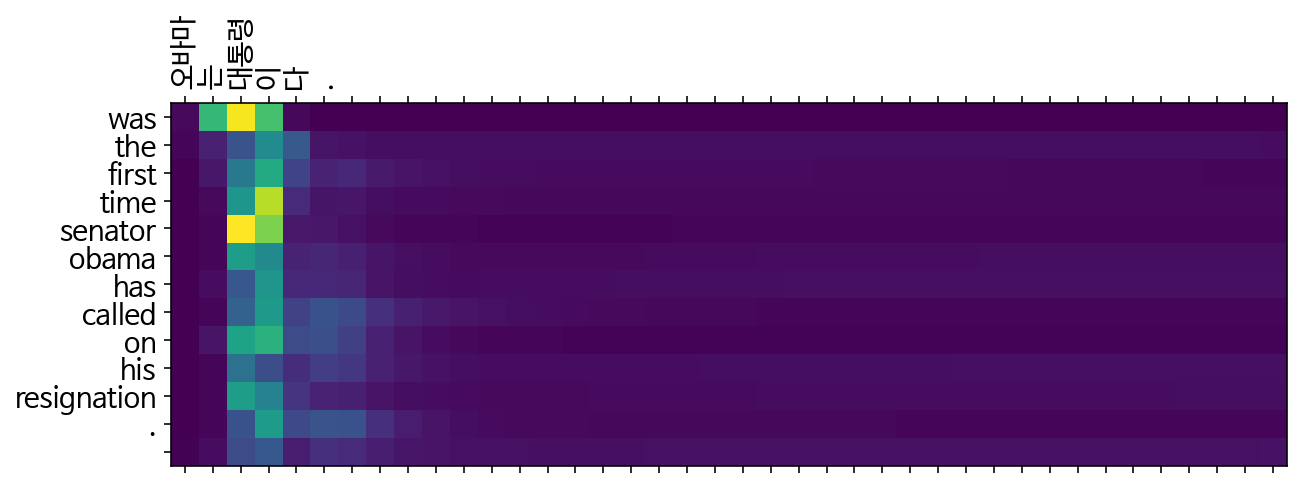

시민들은 도시 속에 산다.  ->  of those tourists are eager to see .


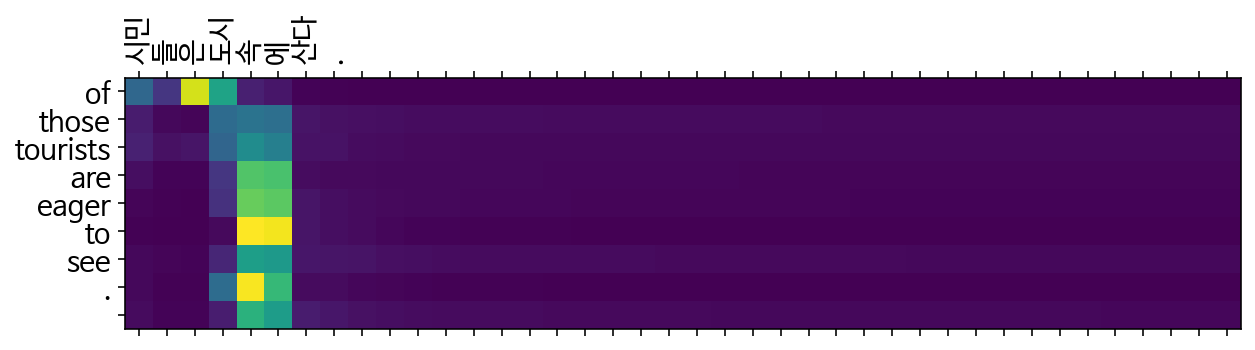

커피는 필요 없다.  ->  coffee is a caffeine buzz .


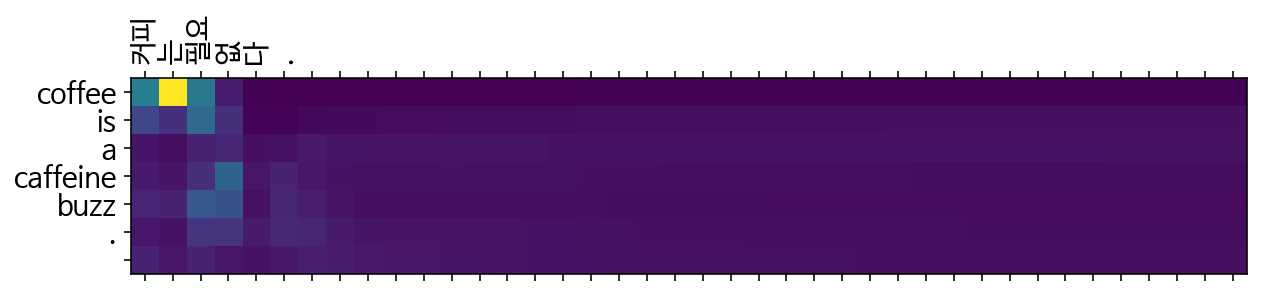

일곱 명의 사망자가 발생했다.  ->  least people have been killed .


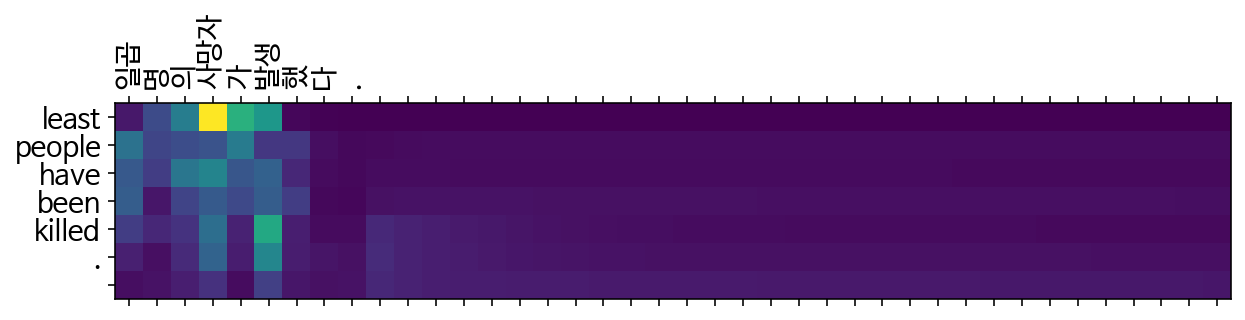

Epoch 7: 100%|██████████| 855/855 [03:59<00:00,  3.57it/s]


Epoch 7, Loss: 1.2722
오바마는 대통령이다.  ->  ' s victory is keeping obama .


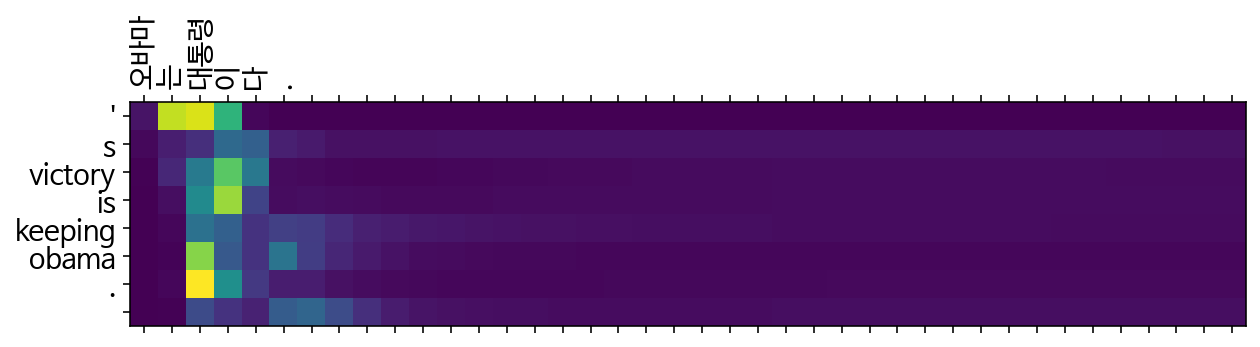

시민들은 도시 속에 산다.  ->  of the city ' s city .


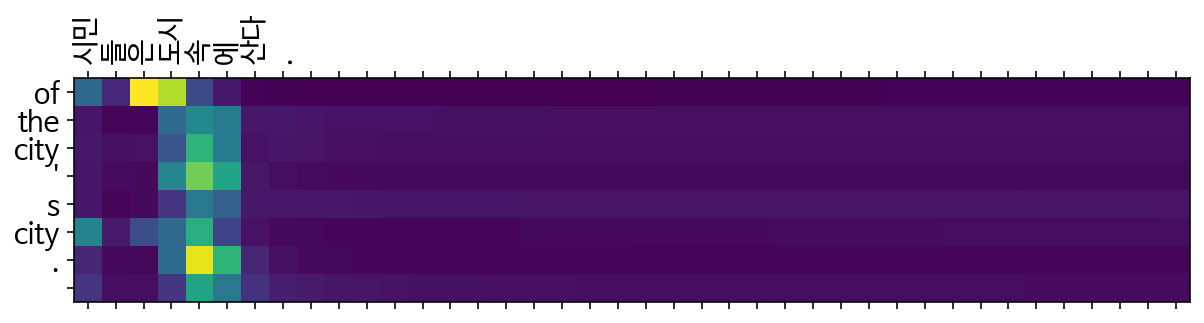

커피는 필요 없다.  ->  coffee is a caffeine buzz .


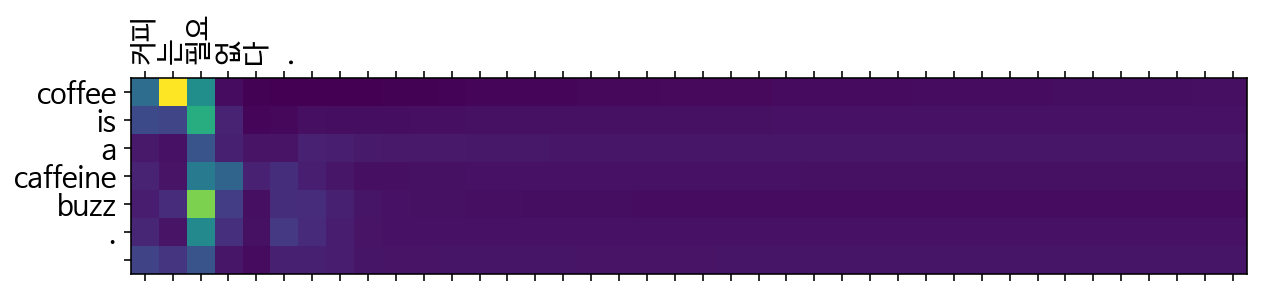

일곱 명의 사망자가 발생했다.  ->  least people have been killed .


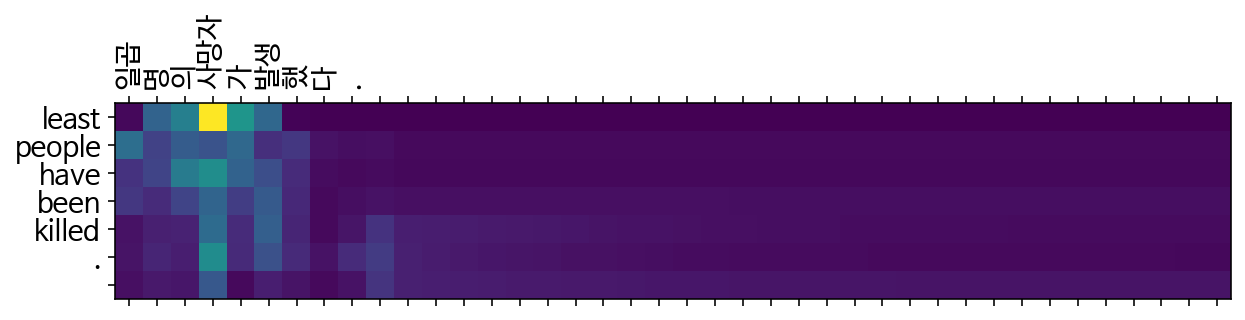

Epoch 8: 100%|██████████| 855/855 [03:59<00:00,  3.57it/s]


Epoch 8, Loss: 1.1451
오바마는 대통령이다.  ->  was the senator ' s head .


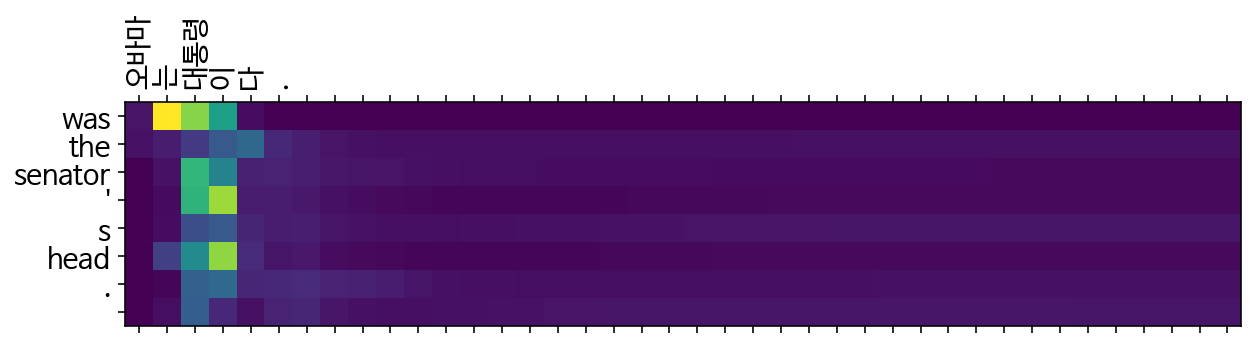

시민들은 도시 속에 산다.  ->  of them take over to a .


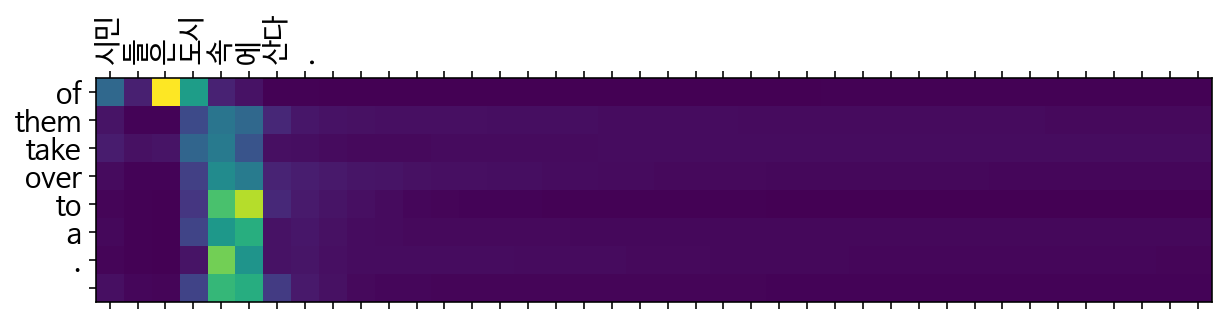

커피는 필요 없다.  ->  coffee is not a .


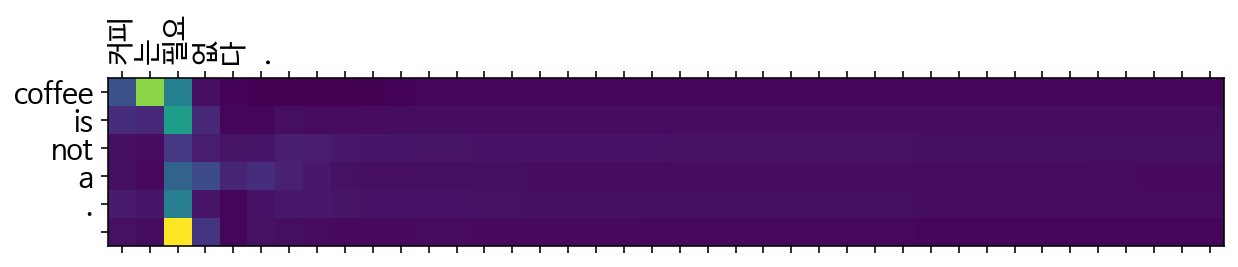

일곱 명의 사망자가 발생했다.  ->  of people have been killed .


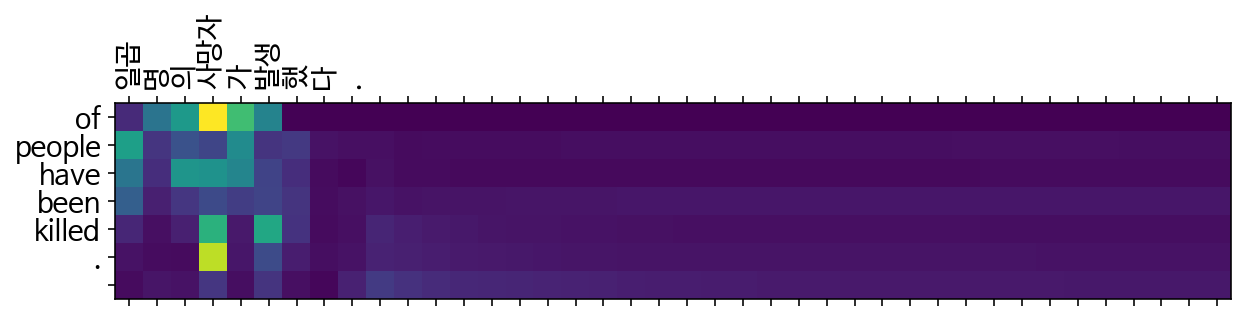

Epoch 9: 100%|██████████| 855/855 [03:59<00:00,  3.57it/s]


Epoch 9, Loss: 1.0326
오바마는 대통령이다.  ->  was the first time senator obama s democratic senator .


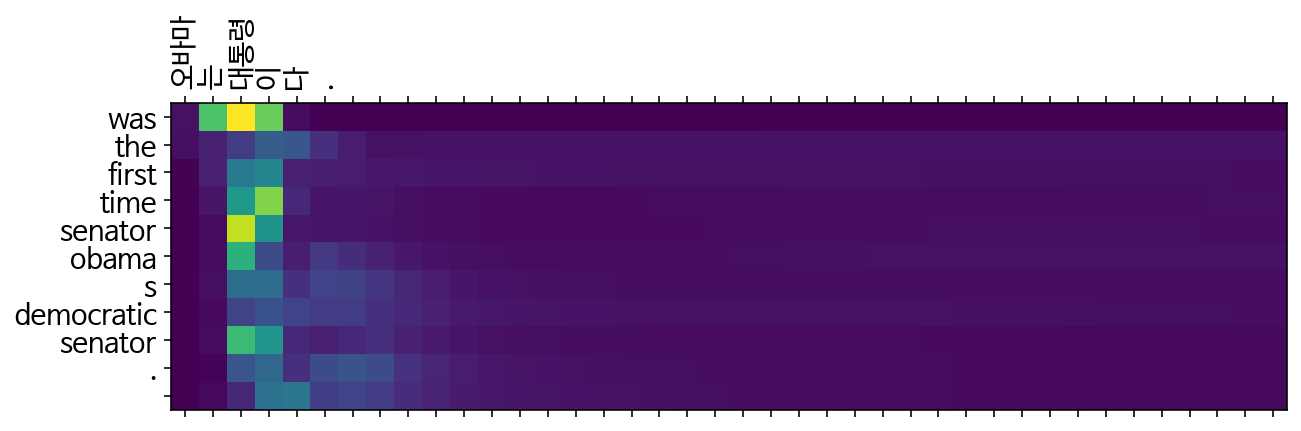

시민들은 도시 속에 산다.  ->  residents in coastal areas have been transformed into a town .


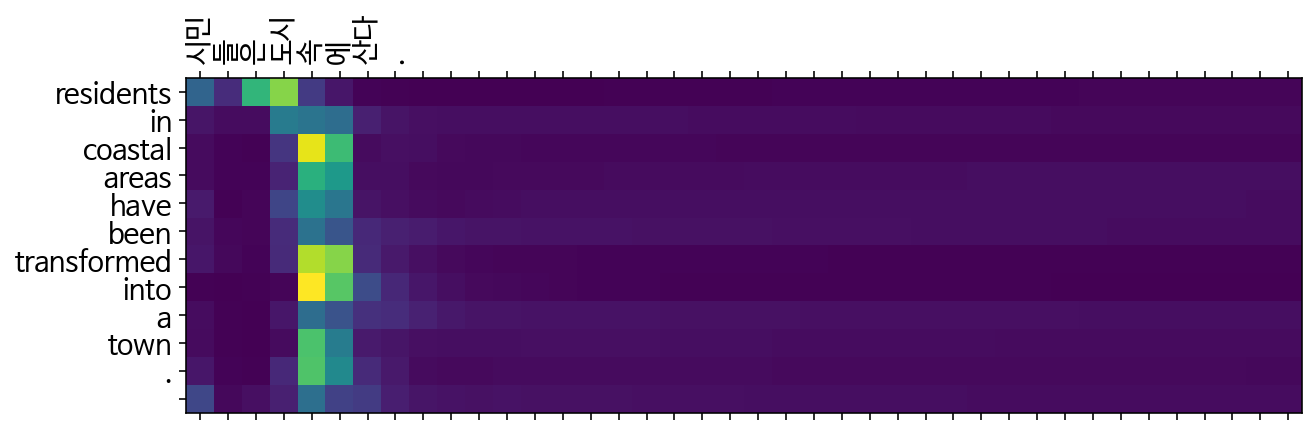

커피는 필요 없다.  ->  coffee is not a good thing .


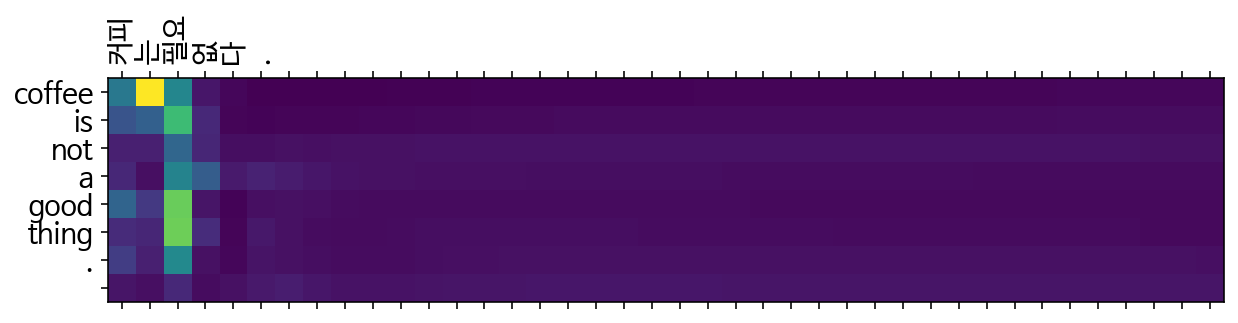

일곱 명의 사망자가 발생했다.  ->  least people were killed .


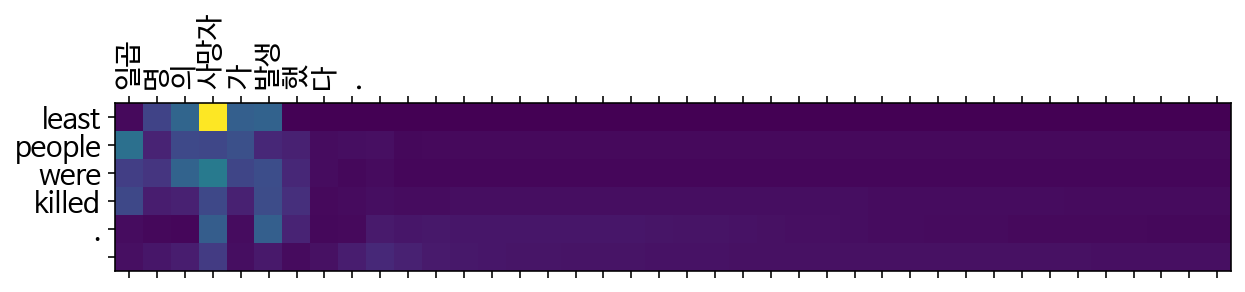

Epoch 10: 100%|██████████| 855/855 [03:59<00:00,  3.57it/s]


Epoch 10, Loss: 0.9334
오바마는 대통령이다.  ->  ' s inauguration , obama said .


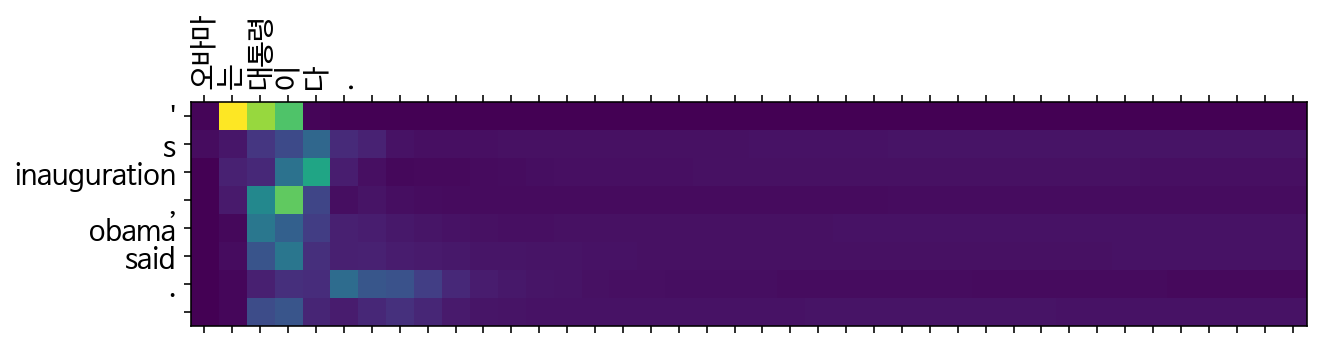

시민들은 도시 속에 산다.  ->  of tourists have to leave .


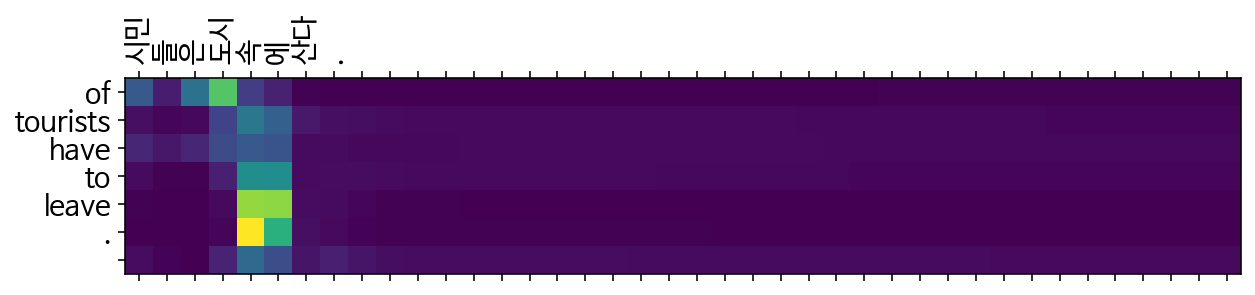

커피는 필요 없다.  ->  coffee is not a big factor .


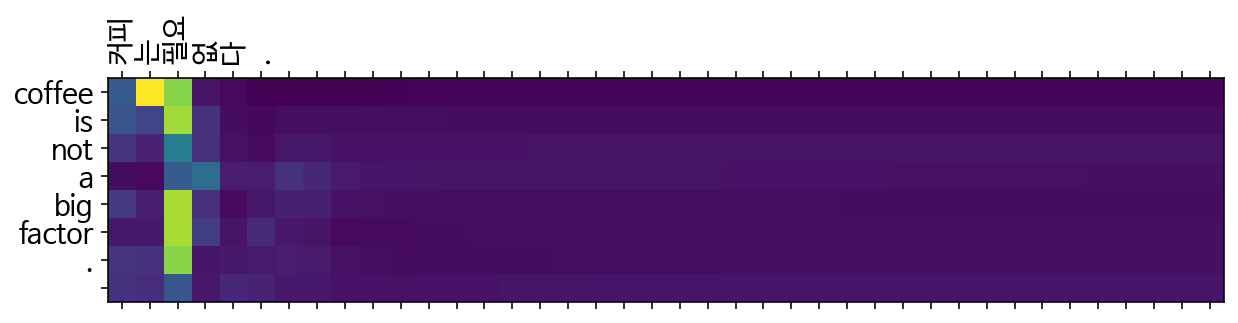

일곱 명의 사망자가 발생했다.  ->  least people were killed .


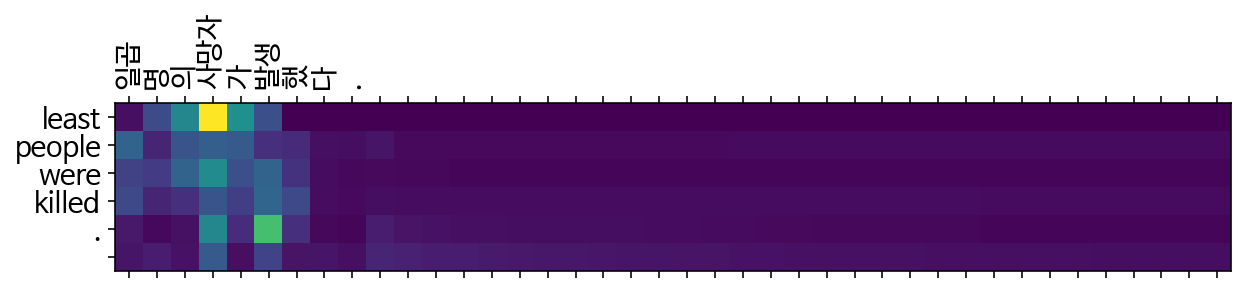

In [26]:
# 모델 훈련
# 학습 루프
EPOCHS = 10
sample_sentences = ["오바마는 대통령이다.", "시민들은 도시 속에 산다.", "커피는 필요 없다.", "일곱 명의 사망자가 발생했다."]
for epoch in range(EPOCHS):
    total_loss = 0
    
    for (batch, (enc_in, dec_in, dec_tar)) in enumerate(tqdm(dataset, desc=f'Epoch {epoch+1}')):
        batch_loss = train_step(enc_in, dec_tar, encoder, decoder, optimizer, eng_tokenizer )
        total_loss += batch_loss
    print(f'Epoch {epoch+1}, Loss: {total_loss/(batch+1):.4f}')
    
    for s in sample_sentences:
        pred_tokens, attn_mat = translate_with_attention(s)
        pred_sentence = ' '.join(pred_tokens)
        print(f"{s}  ->  {pred_sentence}")
        plot_attention(attn_mat, preprocess_sentence(s, lang="kor").split(), pred_tokens)
    


## 결과 분석

- 그나마 괜찮게 나온 결과들을 모은 결과 ( 하나의 훈련 단계의 답이 아님 )
    - 오바마는 대통령이다.  ->  is the president .
    - 시민들은 도시 속에 산다.  ->  of the city ' s city .
    - 커피는 필요 없다.  ->  coffee is not a big factor.
    - 일곱 명의 사망자가 발생했다.  ->  least people were killed
        - 어떤 문장은 훈련 초기에 괜찮게 나오다가 오히려 나중에 더 이상해지고, 계속 비슷한 결과가 나오는 것도 있다. 
        - 왜 학습이 진행되면서 loss는 내려가는데 왜 더 안좋은 결과를 내는가? 데이터의 이상으로 인한 잘못된 학습 원인 추측
         ( Epoch 1, Loss: 2.4834 -> Epoch 10, Loss: 0.9334 )

- 데이터 분석을 하며 추가로 시도할 것들을 정리했으나 컴퓨터 이상으로 훈련단계가 원활하지 않아 일부 기본적인 것만 적용 테스트 후 추가 실험 못함
    - 적용한 것
        - 언어별로도 중복 제거
        - 해당 언어가 한글자도 없는 경우 제거 
    - 적용해보지 못한 아이디어
        - 한영 토큰 비율이 지나치게 낮거나 높은 문장을 제외하기 ( 이걸 적용 안한것이 아쉽다. 첫 실험에서 적용할것을... )
        - 숫자나 영문이 포함된 한국어 입력에 대한 처리
            - 특수 토큰으로 대체 후 원문 copy하는 방식  - 후처리 필요
            - 한문자 단위로 토큰화하기 - 토큰수가 늘어나므로 비용 증가
        - URL 등 특수한 경우에 대한 처리 
        - dropout 적용
        - 하이퍼파라미터 최적화
        - 파일에 존재하는 테스트 파일을 이용한 validation 추가
        - 제대로 된 번역 데이터만 사용 방법에 대한 고민 => AI 이용? 

- 주어진 데이터를 분석해봤을때 학습을 위한 데이터라고 하기에는 너무 틀리거나 맞지 않는 부분이 있어 데이터 분석에 시간 과투자
    - 전처리를 하면서 어떤 데이터를 버리고 어떤 데이터를 취할 것인가에 대해 고민에 시간이 많이 투자됨
    - 실제 모델 훈련 시간 부족으로 실험 시간 부족
        
- 데이터의 숫자 부분을 모두 제거하는 기본 방식만 적용때문에 마지막 문장이 숫자가 잘 안나온 것인가라는 생각이 들었지만 확인 결과 일곱에 대응되는 least seven 이 꽤 있었다. 왜 seven이 아닌 least 가 우선 예측되도록 학습 되었는지는 모르겠다.
 


## 회고
- 데이터 전처리를 어떻게해야할지 고민을 하다가 시간을 많이 보내고 실제 적용은 하지 못해서 아쉬움이 많이 남는다
- 만족할만한 번역 결과를 얻지는 못했지만 훈련 단계별로 번역 예측이 변화하는 부분이나 attention map 으로 시각적으로 보이는 변화가 흥미로웠다. 그것이 무엇인지 정확히 해석하진 못하지만 훈련 단계에서 변화하는 것들이 눈으로 보이니 그저 흥미로웠을뿐이다. 이런 것들이 정보가 되어 모델을 디버깅하거나 할 때 이용할 수 있다고 본거 같은데 어떤식으로 봐야하는 것인지 시간이 될 때 공부를 해봐야겠다.
- 이런 저런 것들을 생각하고 여러가지를 비교 실험해볼만하다고 생각이 들긴했으나 모델의 훈련 시간도 길고 어려운 문제였다. 팀원들도 이번엔 다들 늦어지고 있어서 분담까지 생각하기 힘들었던것 같다.이론이나 실습을 조금 더 빨리 끝내고 분석하면서 실험할 것들을 나눌수 있다면 좀 더 다양한 실험을 해볼 수 있겠다는 생각이 들지만 과연 다음 프로젝트는 그렇게 할 수 있을까? 여전히 시간 부족에 허덕이고 있을것 같다. 그래도 다양한 실험이 필요한 부분이 있다면 다음엔 팀에서 나눠서 진행을 할 수 있도록 해봐야겠다.
- 그리고 다시 훈련을 돌릴 시간이 없어서 그대로 두긴했지만, epoch 마다 attention map 이 너무 가로로 길게 늘어져있는 부분도 아쉽다. 훈련 단계별로 번역 결과와 attention map을 분리해 따로 한줄이나 두줄로 그렸으면 깔끔해서 비교하며 보기 좋을듯하다. 